<a href="https://colab.research.google.com/github/JOTHEESS/MachineLearning_Projects/blob/main/CNN_for_Medical_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Problem:

- More than 1 million people are hospitalized with pneumonia, which is a very serious problem
- Chest X-rays are currently the best available method for diagnosing it
- Suppose You are working as a Data Scientist at Qure.ai (a Medical startup) and want to Classify if a person has pneumonia or not.
  - You also have to deploy the model on mobile device for real time inferences

  - Please go through this link to know about the existing apps in medical domain :
  
      https://www.grantsformedical.com/apps-for-medical-diagnosis.html

- This was especially useful during the times when COVID-19 was known to cause pneumonia.


<img src='https://drive.google.com/uc?id=1Qc7aF9zBzFz-I6lnhXZK1IOQjwLTfET5' width=400>


   - Image on the left is a normal,
    but on the right we can see severe glass opacity mainly due to air displacement by fluids




## Brief intro:

What is Pneumonia?

- Pneumonia is an infection that inflames the air sacs in one or both lungs.
- The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing.
- A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

- Pneumonia can range in seriousness from mild to life-threatening.
- It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

<img src='https://drive.google.com/uc?id=1I7HBz2uVPq8SOcjC7el86EZR8kfxy6aK' width=300>

### Real time constraints:
- Low latency requirements
- False negative or positives can be risky
   - If a person has Pneumonia and your model predicted as Normal
   - If a person is Normal and your model predicted as Pneumonia
- Model should be confident in deciding the class
- Model explainability through visualizations

In [1]:
# Importing required libraries

import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# Specifying our training batch size
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Specifying the image size
IMAGE_SIZE = [224, 224]

# List containing class names, which will be used to index on our model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [5]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [6]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Normal images count in training set: 1349
Pneumonia images count in training set: 3883
Total Count of images: 5232


- Notice that there are way more images that are classified as pneumonia than normal.
- This shows that we have an **imbalance** in our data i.e our model can be biased towards high majority class (Pneumonia in our case)





- Here Data augmentation will not be useful because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images.

- We will correct for this imbalance later using class weights

In [7]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


- The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia).
- Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

### Creating (Image, Label) pair :

- We want to map each filename to the corresponding (image, label) pair.

- As we only have two labels, we will encode the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

Let's split the data into a training and validation datasets.

In [9]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.skip(4300)

Let's visualize the shape of an (image, label) pair.

In [10]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


Load and format the test data as well.

In [11]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [12]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(BATCH_SIZE)

In [13]:
def prepare_for_training(ds, cache=True):


    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)


    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [14]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

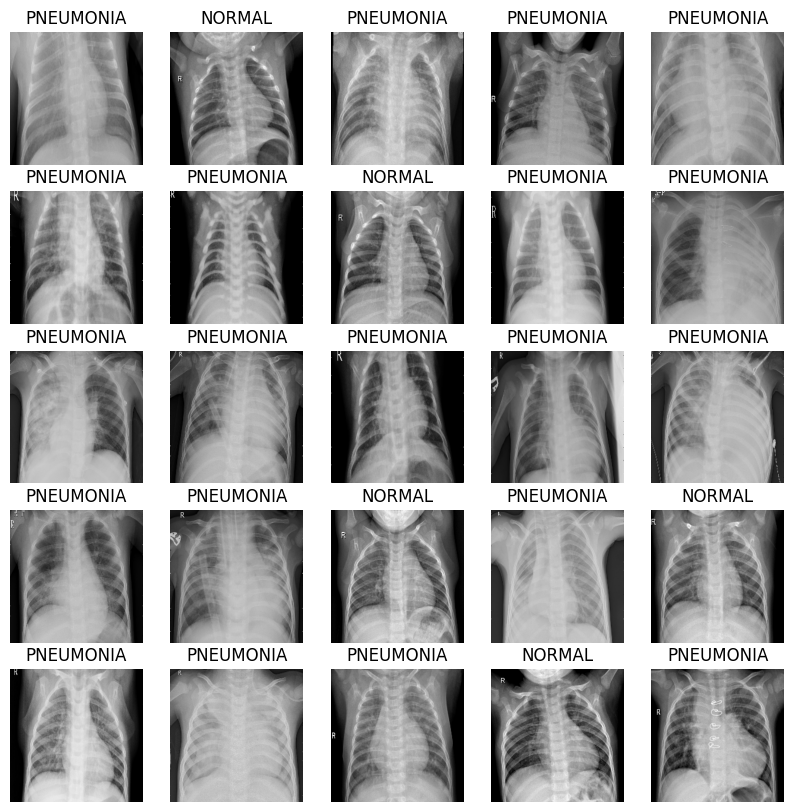

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

## MobileNet: Why and How ?


We move on to building and training our model.

- While working with Image datasets, some state-of-the-art models include ResNet50, InceptionNet, VGG16, AlexNet, etc.
- These model architectures do achieve groundbreaking accuracies on ImageNet Dataset but are computationally heavy to train and perform model inference

MobileNet is one of the smallest Deep Neural networks that are fast and efficient and can be run on devices without high-end GPUs.
Implementation of these networks is very simple when using a framework such as Keras (on TensorFlow).





### Using MobileNet:


| Model Name | Number of params | Top 1 Acc | Top 5 Acc |
| --- | --- | --- | --- |
| MobileNet | 2.3M | 71.0| 90.5
| ResNet50 | 25.6M | 76 | 93
| Inception | 11.2M | 74.8 |92.2
| VGG16 | 138M | 74.4 | 91.9
| AlexNet | 62M | 63.3 | 84.6

- We need to design networks with low parameters, MobileNet is one such model
- Before jumping into details, Lets compare metric of ResNet50 and MobileNet
- MobileNet has 90.5 top 5 acc which is still good, given the fact that it has only 2.5 M parameters
- MobileNet is majorily used for on-device mobile inference, running on Tensorflow Lite (TFlite)
- TFlite is a subset of TF, having only necessary functions so we can install the package on low resource devices

In [17]:
import tensorflow as tf

#import all necessary layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense

from tensorflow.keras import Model

In [18]:
# MobileNet block
def mobilnet_block (x, filters, strides):

    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

In [19]:
#stem of the model
input = Input(shape = (224, 224, 3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

In [20]:
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
output = Dense (units = 1000, activation = 'softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128   

In [22]:
!pip install pydot


In [24]:
!pip install graphviz



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.9 MB/s eta 0:00:00


In [26]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as fintuning the model

    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    # for layer in mobilenet_model.layers:
    #     layer.trainable = False


    #Output of base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

In [27]:
finetuned_mobilenet = build_model()

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [29]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

We also want to tune our learning rate.
  - Too high of a learning rate will cause the model
to diverge.
  - Too small of a learning rate will cause the model to be too slow. We
implement the exponential learning rate scheduling method below.

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [32]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### Training the model:

In [38]:


# Make sure both the images and labels are cast to the appropriate types

train_ds_batch = train_ds_batch.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)))
val_ds_batch = val_ds_batch.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)))

with strategy.scope():
    finetuned_mobilenet = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

    finetuned_mobilenet.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

    history = finetuned_mobilenet.fit(
        train_ds_batch,
        epochs=10,
        validation_data=val_ds_batch,
        class_weight=class_weight,  # Assuming class_weight is already defined
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]  # Assuming callbacks are defined
    )


Epoch 1/10
135/135 [==============================] - 43s 275ms/step - loss: 0.3871 - binary_accuracy: 0.8807 - precision: 0.9578 - recall: 0.8776 - val_loss: 0.4269 - val_binary_accuracy: 0.7715 - val_precision: 0.7634 - val_recall: 0.9985 - lr: 0.0100
Epoch 2/10
135/135 [==============================] - 33s 244ms/step - loss: 0.1912 - binary_accuracy: 0.9260 - precision: 0.9796 - recall: 0.9193 - val_loss: 0.2662 - val_binary_accuracy: 0.8745 - val_precision: 0.8568 - val_recall: 0.9956 - lr: 0.0089
Epoch 3/10
135/135 [==============================] - 33s 247ms/step - loss: 0.1594 - binary_accuracy: 0.9372 - precision: 0.9828 - recall: 0.9316 - val_loss: 0.2663 - val_binary_accuracy: 0.8734 - val_precision: 0.8557 - val_recall: 0.9956 - lr: 0.0079
Epoch 4/10
135/135 [==============================] - 34s 250ms/step - loss: 0.1405 - binary_accuracy: 0.9414 - precision: 0.9851 - recall: 0.9350 - val_loss: 0.2546 - val_binary_accuracy: 0.8766 - val_precision: 0.8608 - val_recall: 0.99

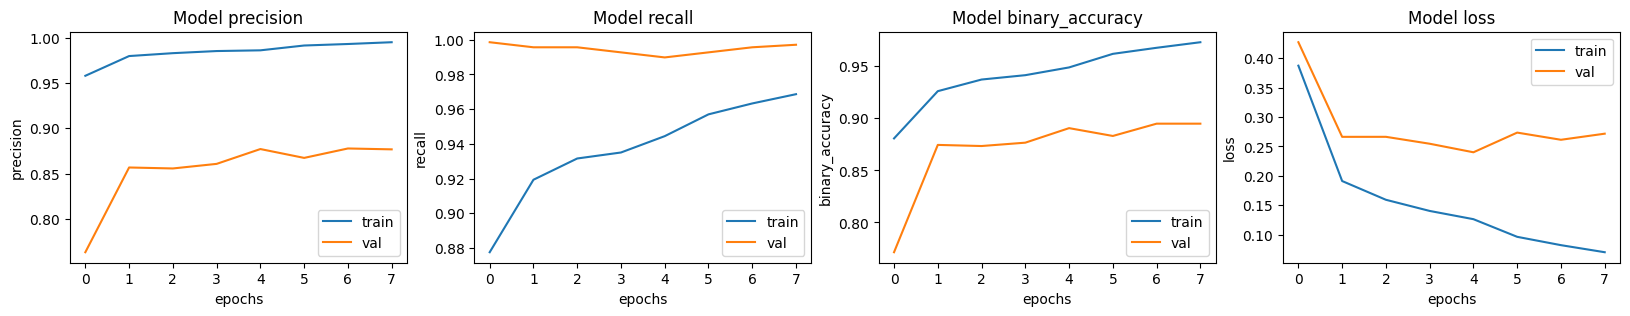

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

### Loading the Model



In [40]:
loaded_mobilenet = tf.keras.models.load_model('xray_model.h5')

## Evaluate model

Let's evaluate the model on our test data!

In [41]:
loaded_mobilenet.evaluate(test_ds_batch, return_dict=True)

20/20 [==============================] - 7s 183ms/step - loss: 1.0669 - binary_accuracy: 0.6635 - precision: 0.6515 - recall: 0.9923


{'loss': 1.0669280290603638,
 'binary_accuracy': 0.6634615659713745,
 'precision': 0.6515151262283325,
 'recall': 0.9923076629638672}

- We see that our accuracy on our test data is 66%,


 recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified.
- We should aim to increase our precision.
   

Predicting on a test image using our trained MobileNet Model

2/2 [==============================] - 2s 266ms/step
This image is 4.20 percent NORMAL
This image is 95.80 percent PNEUMONIA
CPU times: user 24 µs, sys: 44 µs, total: 68 µs
Wall time: 134 µs


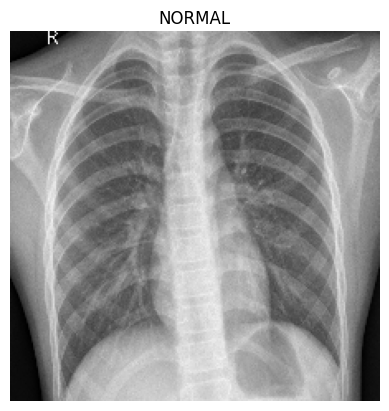

In [43]:
for image, label in test_ds_batch.take(2):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
%time

## Confusion Matrix

In [44]:
label_list = []
prediction_list = []

for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image)
    label = tf.where(label, 1, 0)

    if prediction > 0.5 :
        prediction = 1
    else :
        prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)

1/1 [==============================] - 0s 42ms/step


In [45]:
test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)

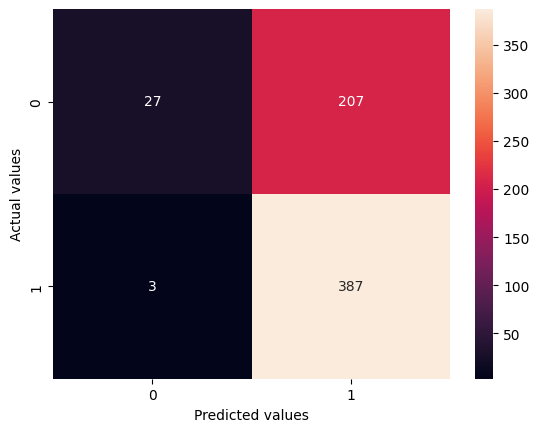

In [46]:
ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')

plt.show()

High False Positives (207):
The model is incorrectly predicting a large number of negative cases as positive, which suggests a bias towards predicting positive classes (perhaps due to class imbalance).
Low False Negatives (3):
The model rarely misses positive cases, which means it is doing well at detecting positive instances (e.g., pneumonia), which is usually important in medical applications.

**How can we check what region in the image our CNN is focusing on ?**

* With the help of **GradCAM(Gradient-weighted Class Activation Map**) algorithm.
* It helps to find out the region on which **CNN is focusing on to predict particular class**.

Since we need the last Convolution layer for implementing our GRADCAM Algorithm, </br>
we print every Conv. layer name in our pretrained_modbilenet model

In [47]:
for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


Last convolutional layer for GRADCAM is expanded_conv_project_BN

In [48]:
last_conv_layer_name = finetuned_mobilenet.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

In [49]:
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00


2/2 [==============================] - 1s 218ms/step
This image is 4.20 percent NORMAL
This image is 95.80 percent PNEUMONIA


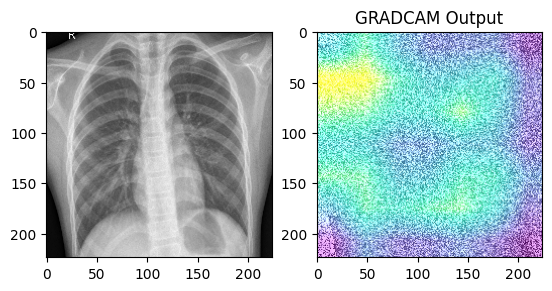

In [50]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):

    data = ([image[2].numpy()], None)
    # print('Original label',CLASS_NAMES[label[2].numpy()])
    image = image[2] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()

### Loading pretrained efficientnet:
https://keras.io/api/applications/efficientnet/

In [51]:
with strategy.scope():
    pretrained_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # fine-tuning

    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.efficientnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

165234480/165234480 [==============================] - 1s 0us/step
